# Data exploration
- Crosstab and pivot table
- Visualize outliers in credit data
- Missing data

In [1]:
# import pakages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Note that the data frames in this notebook contains different features,  <br> **as well as a label column `loan_status` shows whether the loan is currently in default with 1 being default and 0 being non-default.**

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
32581 rows and 12 columns


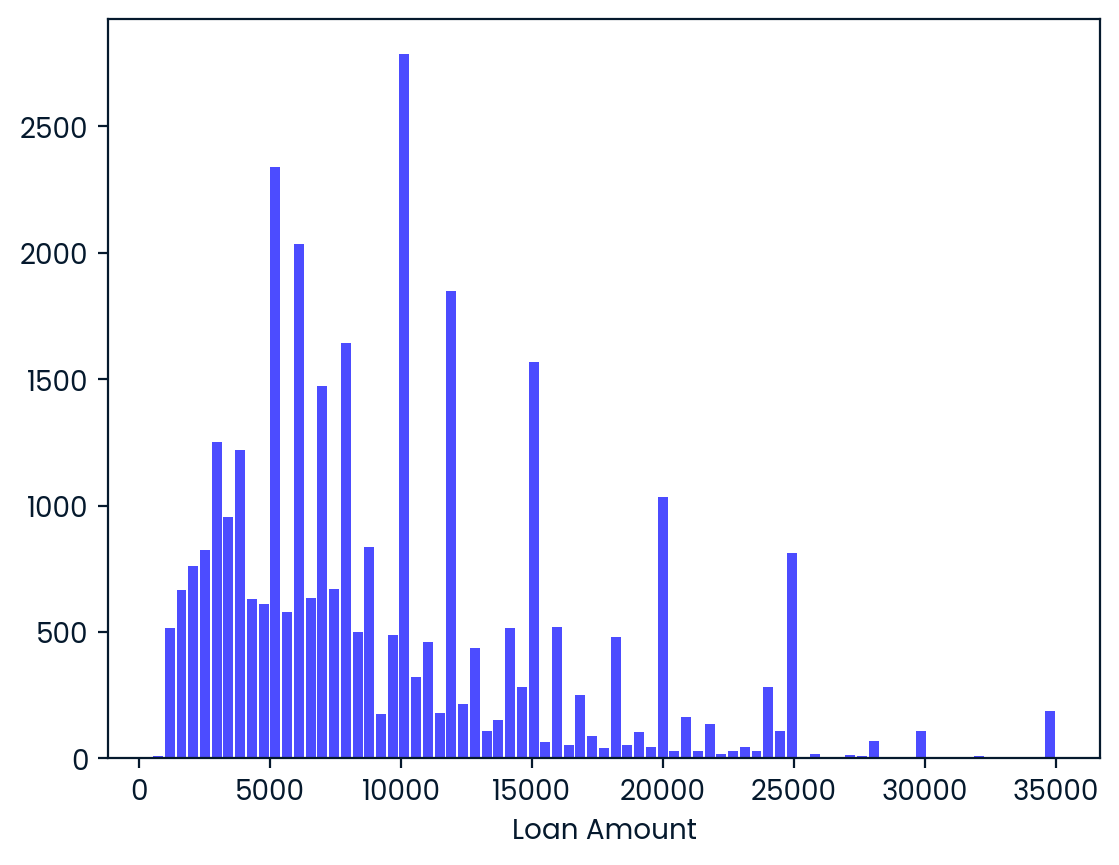

In [2]:
# import data
path = "datasets/cr_loan2.csv"
cr_loan = pd.read_csv(path)
# Check the structure of the data
print(cr_loan.dtypes)
print(f"{cr_loan.shape[0]} rows and {cr_loan.shape[1]} columns")

# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

### cross tables
Cross tables can be used for a high level view of selected columns and even aggregation.

In [3]:
# Create a cross table of the loan intent and loan status
print(pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True))

# Create a cross table of home ownership, loan status, and average percent income
print(pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean'))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581
loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


### outlier data
Outliers can affect the performance of the model. It's usually caused by human mistake or system bugs in the data recording process.

Outlier data can be detected from multiple ways.

In [4]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
        values=cr_loan['person_emp_length'], aggfunc='max'))
# # person_emp_length > 100 seems very unrealistic

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


The maximum employment length is > 100 for non-default mortgage loaner and default rent loaner, which seems very unrealistic. <br>
We can drop these rows to avoid biased results.

In [5]:
# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
cr_loan_new = cr_loan.drop(indices)

# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max']))

                           min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0


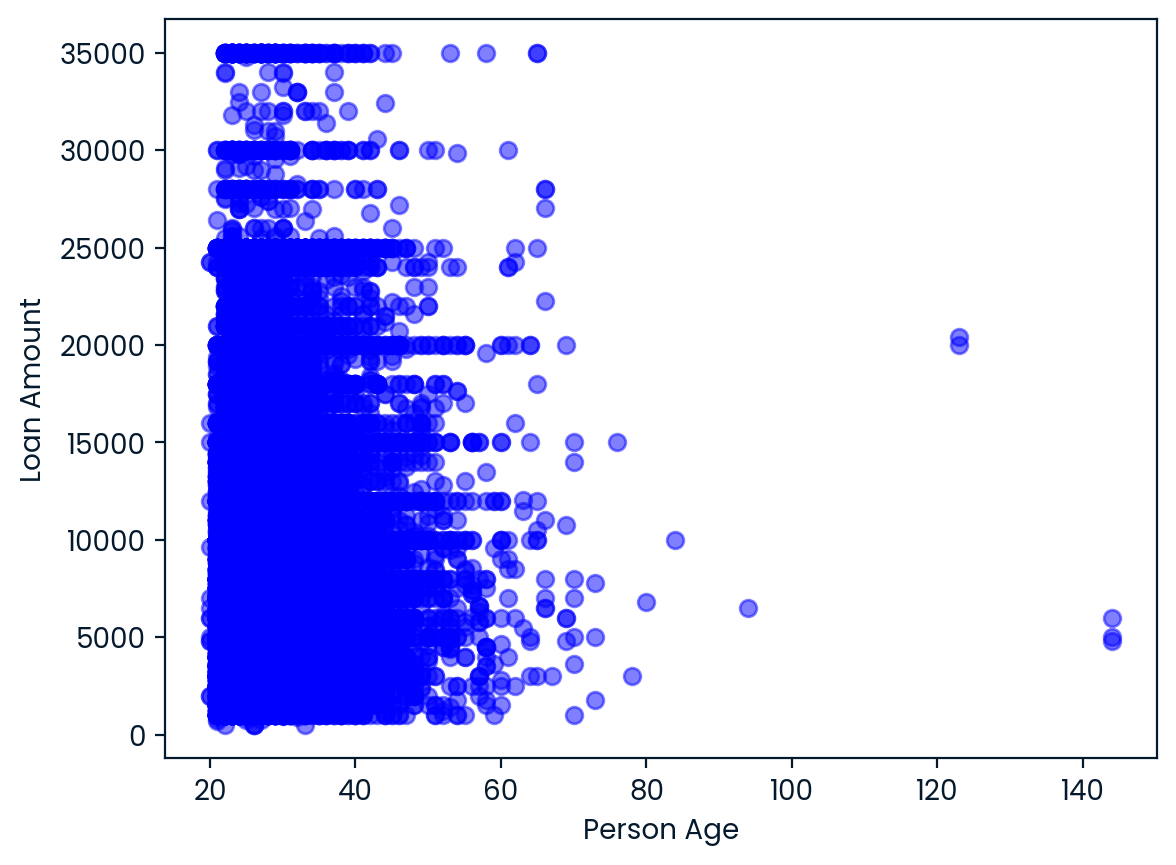

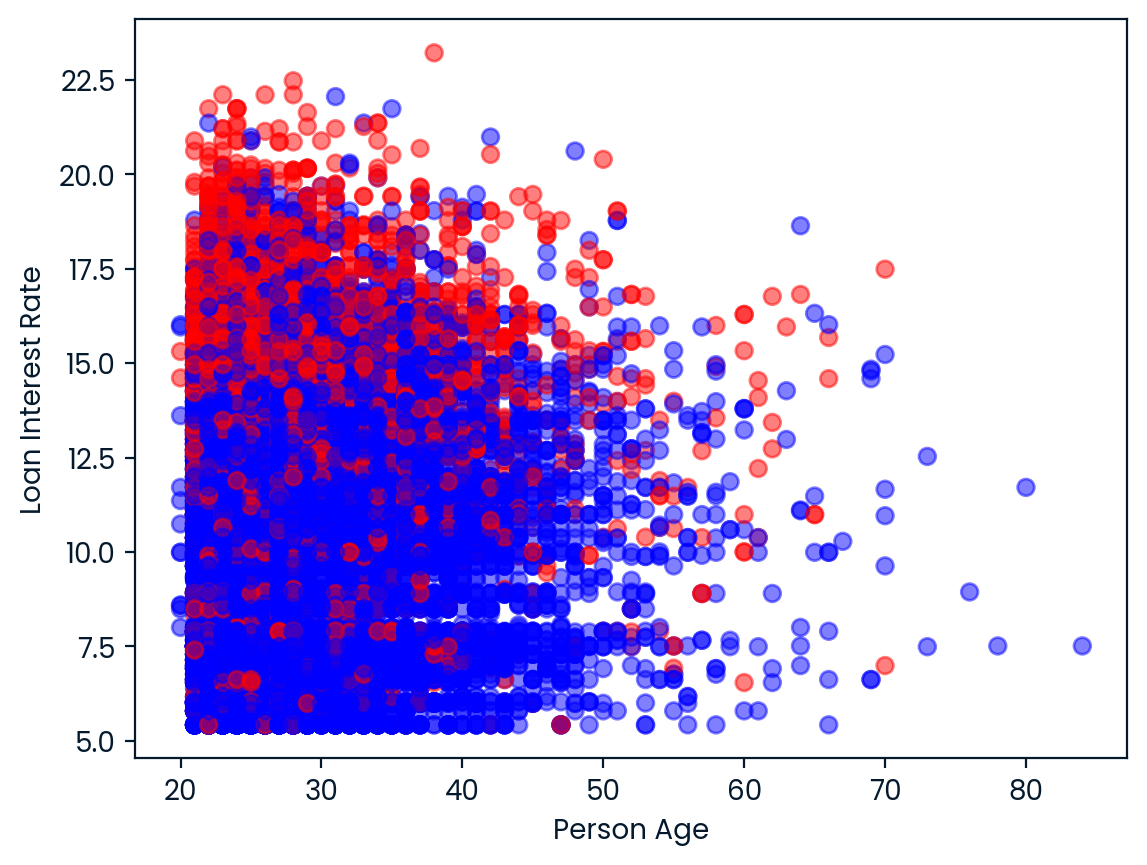

In [6]:
# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()
# # age much greater than 100 also looks strange

# Use Pandas to drop the record from the data frame and create a new one
cr_loan_new = cr_loan.drop(cr_loan[cr_loan['person_age'] > 100].index)

# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan_new['person_age'], cr_loan_new['loan_int_rate'],
            c = cr_loan_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

### missing data
Similar to outlier data, missing data can also impact the performance either positively or negatively. It may exist in numerical data and catagorical data.
There are different ways to handle the missing data.

Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  ...  cb_person_cred_hist_length
105          22  ...                           4
222          24  ...                           2
379          24  ...                           3
407          25  ...                           2
408          22  ...                           3

[5 rows x 12 columns]


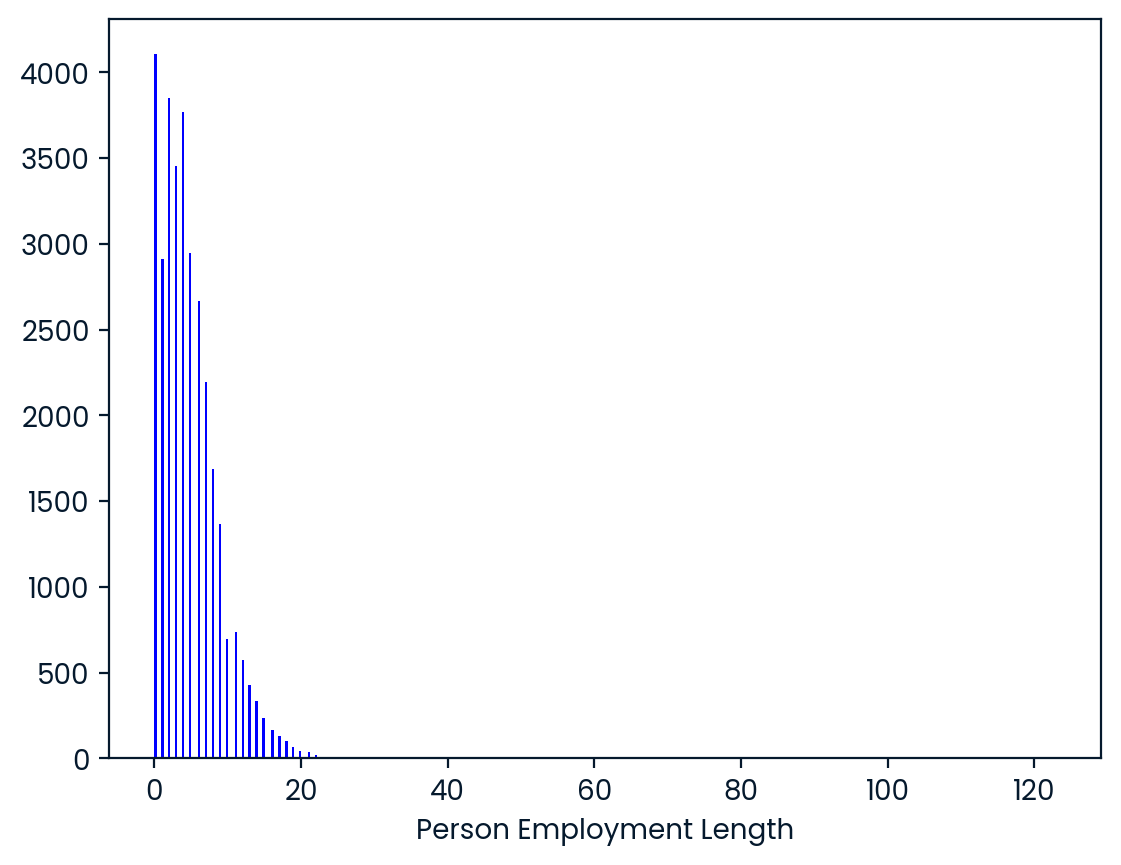

In [7]:
# Print a null value column array
print(cr_loan.columns[cr_loan.isnull().any()])

# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan['person_emp_length'].isnull()].head())

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [8]:
# Print the number of nulls
print(cr_loan['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)

cr_loan_clean.shape

3116


(29465, 12)

# Logistic Regression for Probability of Default
- Probability of Default: the likelihood that someone will default on a loan (between 0 and 1)
- `loan_status`: `0` for non-default, `1` for default

Logistic regression coefficient: $[\beta_1, \beta_2, \beta_3, ...]$ 

Probability: $P(loanstatus=1) = \frac{1}{1 + exp(-Z)}$, where $Z = \beta_0 + \sum_{i=1} \beta_i x_i$

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Simple Logistic Regression with a few numeric data
using the `LogisticRegression()` model to `fit(X_train, y_train)`

In [10]:
# A simple LogisticRegression with multiple numeric data:

# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 8.34020099e-02 -6.02470833e-02 -3.28983416e-05]]


### One-hot encoding
Transform categorical data from string to numerical datas of `0` and `1`

In [11]:
# One-hot encoding categorical data:

# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(cr_loan_prep.columns)

# Use test_train_split to create the training and test sets
y = cr_loan_prep[['loan_status']]
X = cr_loan_prep.drop('loan_status',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of predictions
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Concatenate and print the two data frames for comparison
print(pd.concat([y_test.head().reset_index(drop = True), preds_df.head()], axis = 1))

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')
   loan_status  prob_default
0            0      0.129805
1            0      0.243161
2            0      0.100325
3            0      0.252148
4            0      0.377654


### classification report
Reassign predicted probability to 0 and 1 with 0.5 threshold and compared predicted defaults with true defaults

We need to convert the `prob_default` result to a binary value similar to `loan_status` by setting the threshold in the probability. The performance of the credit model can be evaluated through classification reporting containing different scores. Both the credit model itself and the threshold setting can affect the performance.

In [12]:
from sklearn.metrics import classification_report

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

0    11219
1      567
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9194
     Default       0.73      0.16      0.26      2592

    accuracy                           0.80     11786
   macro avg       0.77      0.57      0.57     11786
weighted avg       0.79      0.80      0.75     11786



Note that the default recall for this model is very low.

In [13]:
# Print all the non-average values from the report

from sklearn.metrics import precision_recall_fscore_support

print("Compute precision, recall, F-measure and support for each class:")
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

print(f"Accuracy score of model {clf_logistic.score(X_test, y_test)}")


Compute precision, recall, F-measure and support for each class:
(array([0.80577592, 0.72839506]), array([0.98324995, 0.15933642]), array([0.88571009, 0.26147515]), array([9194, 2592]))
Accuracy score of model 0.8020532835567623


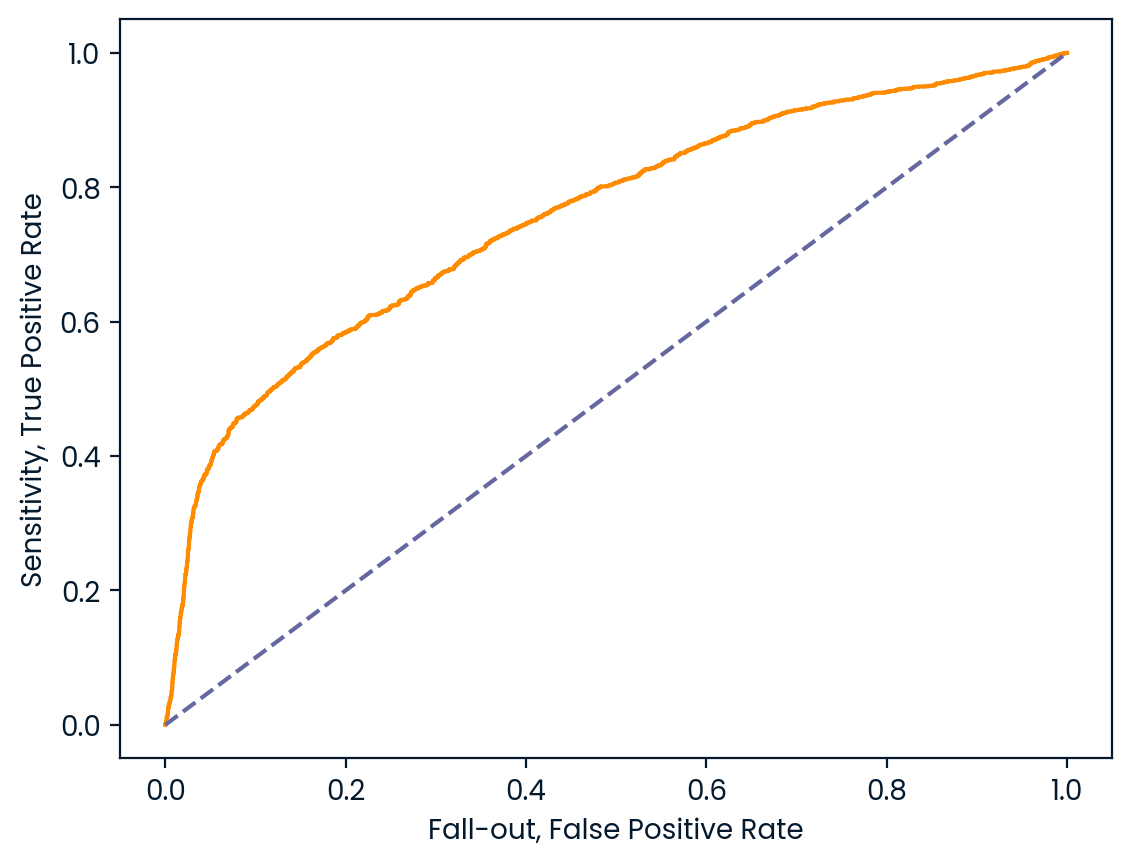

[1.79120258e+000 7.91202579e-001 7.83364753e-001 ... 2.09339193e-011
 7.38590451e-012 5.87884914e-108]
auc score of teh model is 0.7568318173151034


In [14]:
# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve, roc_auc_score

prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange', label='roc-curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Fall-out, False Positive Rate')
plt.ylabel('Sensitivity, True Positive Rate')
plt.show()

print(thresholds)

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(f"auc score of teh model is {auc}")

### confusion matrix
|TN|FP|

|FN|TP|


In [15]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix based on 0.5 defualt threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
print("With a theshold of 0.5: ")
print(confusion_matrix(y_test,preds_df['loan_status']))

# Print the confusion matrix based on 0.4 defualt threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
print("With a theshold of 0.4: ")
print(confusion_matrix(y_test,preds_df['loan_status']))

With a theshold of 0.5: 
[[9040  154]
 [2179  413]]
With a theshold of 0.4: 
[[8489  705]
 [1428 1164]]


We are intersted in accurately predicting the defaults.
We can also estimate how this default threshold affect the performance.

In [16]:
# following the 0.4 threshold

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the unexpected loss in dollar amount from new default recall rate
avg_loan_amnt = cr_loan_prep['loan_amnt'].mean()
print(avg_loan_amnt * num_defaults * (1 - default_recall))

9869225.157201577


There is a trade off between metrics like default recall, non-default recall and model accuracy. We can visualize how theses values change according to different default thresholds.

In [17]:
precision_recall_fscore_support(y_test,preds_df['loan_status'])

(array([0.85600484, 0.62279294]),
 array([0.92331956, 0.44907407]),
 array([0.88838889, 0.52185609]),
 array([9194, 2592]))

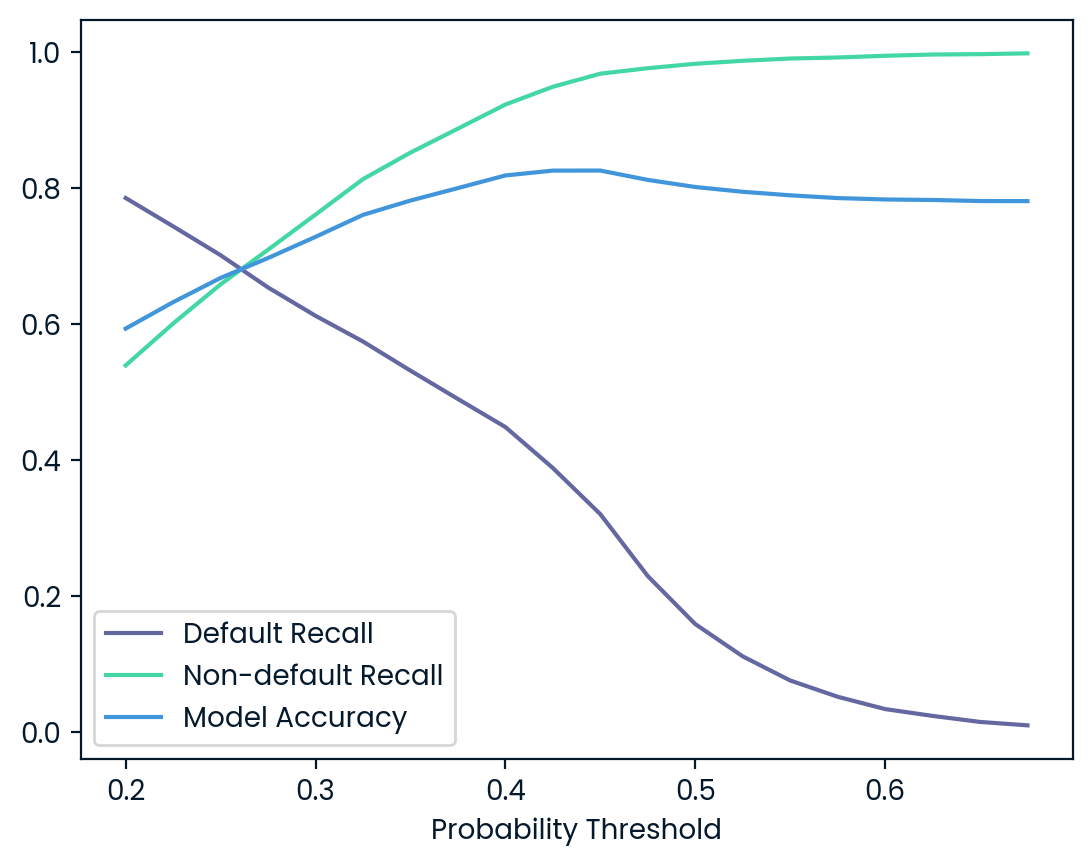

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

thresh = [round(x*0.025+0.2,3) for x in range(20)]
def_recalls = []
nondef_recalls = []
accs = []
for t  in thresh:
    temp_pred = preds_df['prob_default'].apply(lambda x: 1 if x > t else 0)
    def_recalls.append(precision_recall_fscore_support(y_test,temp_pred)[1][1])
    nondef_recalls.append(precision_recall_fscore_support(y_test,temp_pred)[1][0])
    accs.append(accuracy_score(y_test,temp_pred))


plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

The plot shows that thresh=0.275 would maximize the scores evenly.

# Gradient Boosted Trees
Gradient boosted trees can also be trained on the credit data.

Loss function of gbt:
$Log(Loss) = -\frac{1}{N} \sum_{i=1}^N [y_i*log(p_i) + (1-y_i)*log(1-p_i)]$

### train gbt model and assess performance

In [19]:
# Train a model
import xgboost as xgb
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Concatenate and print the two data frames for comparison
print(pd.concat([y_test.reset_index(drop = True), gbt_preds_df], axis = 1).head())

   loan_status  prob_default
0            0      0.069717
1            0      0.000514
2            0      0.001946
3            0      0.045644
4            0      0.432617


There are several ways to assess the model:
- classification report comparing true data and predicted laon status
- column importance from the model

In [20]:
# Predict the loan status with gbt 
gbt_preds_01 = clf_gbt.predict(X_test)
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_01, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9194
     Default       0.96      0.74      0.84      2592

    accuracy                           0.94     11786
   macro avg       0.94      0.87      0.90     11786
weighted avg       0.94      0.94      0.93     11786



{'person_age': 286.0, 'person_income': 787.0, 'person_emp_length': 279.0, 'loan_amnt': 344.0, 'loan_int_rate': 516.0, 'loan_percent_income': 263.0, 'cb_person_cred_hist_length': 159.0, 'person_home_ownership_MORTGAGE': 54.0, 'person_home_ownership_OTHER': 3.0, 'person_home_ownership_OWN': 42.0, 'person_home_ownership_RENT': 61.0, 'loan_intent_DEBTCONSOLIDATION': 64.0, 'loan_intent_EDUCATION': 37.0, 'loan_intent_HOMEIMPROVEMENT': 34.0, 'loan_intent_MEDICAL': 90.0, 'loan_intent_PERSONAL': 49.0, 'loan_intent_VENTURE': 38.0, 'loan_grade_A': 6.0, 'loan_grade_B': 26.0, 'loan_grade_C': 51.0, 'loan_grade_D': 47.0, 'loan_grade_E': 28.0, 'loan_grade_F': 5.0, 'loan_grade_G': 11.0, 'cb_person_default_on_file_N': 28.0}


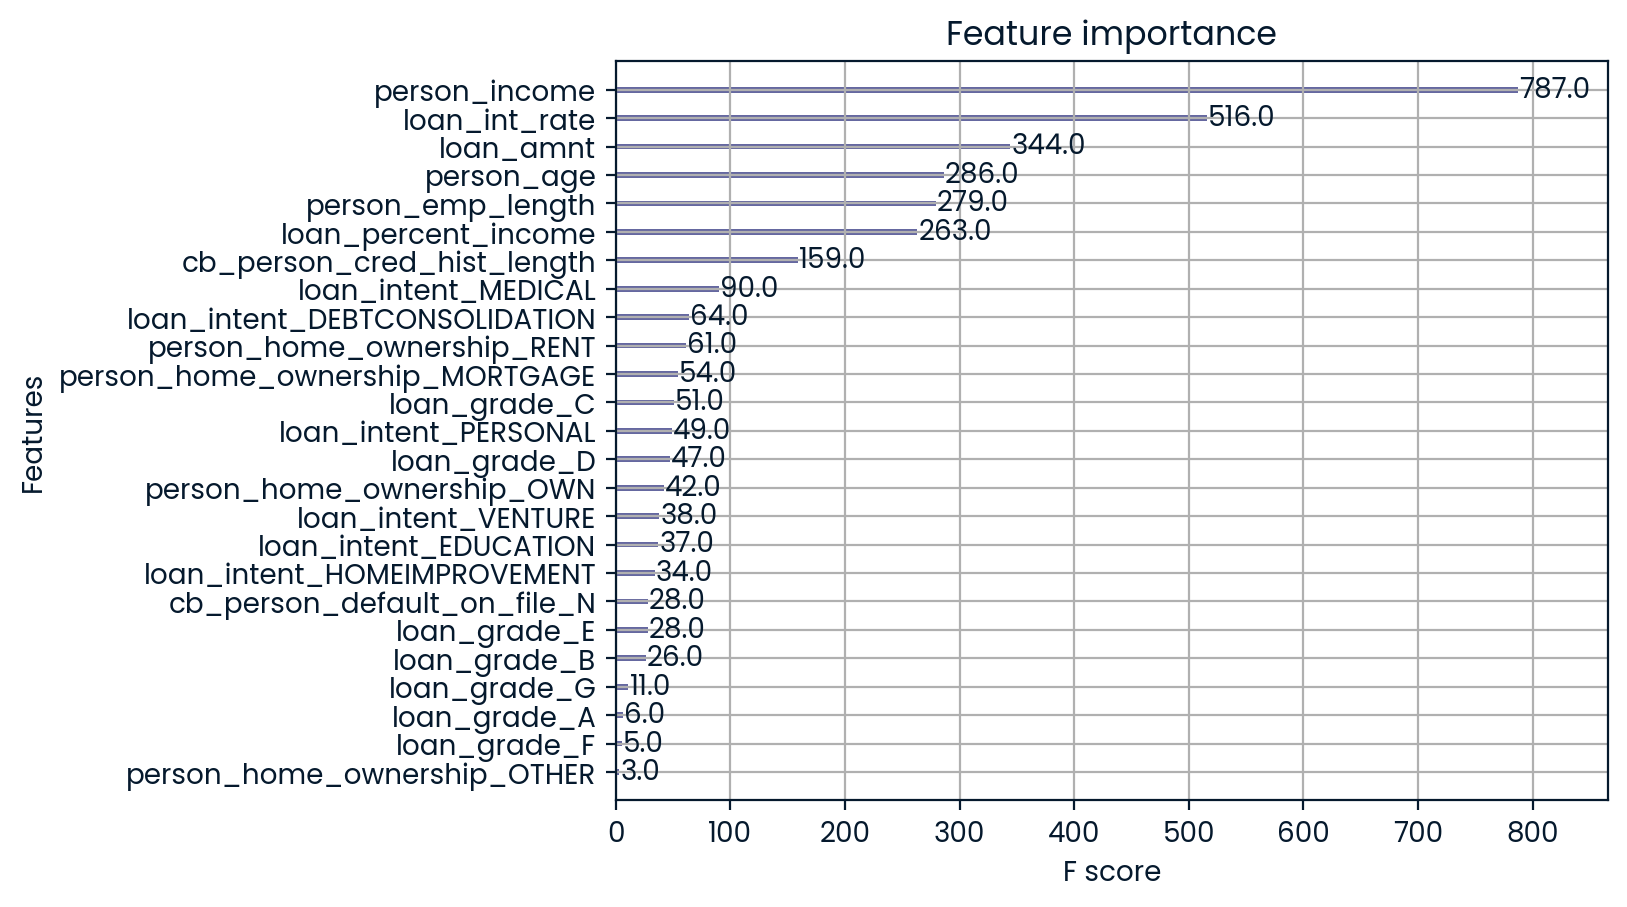

In [21]:
# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

Assuming 20% loss given default, and `loan_amnt` be the exposure at default. <br>
$Expected Loss = PD * LGD * EAD$ <br>
$expected loss = prob\_default * lgd * loan\_amnt$

In [22]:
# Combine probability of default prediction from LogisticRegression() and XGBClassifier()
portfolio = pd.concat([gbt_preds_df.reset_index(drop=True).rename(columns={'prob_default': 'gbt_prob_default'}), preds_df['prob_default'].rename('lr_prob_default')], axis=1)

portfolio['lgd'] = 0.2
portfolio['loan_amnt'] = X_test['loan_amnt'].reset_index(drop=True)


print(portfolio.head())

   gbt_prob_default  lr_prob_default  lgd  loan_amnt
0          0.069717         0.129805  0.2       9000
1          0.000514         0.243161  0.2      11000
2          0.001946         0.100325  0.2       3700
3          0.045644         0.252148  0.2      10800
4          0.432617         0.377654  0.2       7500


In [23]:
# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  5483470.775015296
GBT expected loss:  5299601.591617264


###  cross validation


In [24]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Construct params for cv
params = {
    'objective': 'binary:logistic', 
    'seed': 123, 
    'eval_metric': 'auc'
}

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.895946       0.002250       0.891604      0.009428
1        0.902931       0.003205       0.897648      0.008133
2        0.911381       0.001820       0.905554      0.007240
3        0.915385       0.000750       0.908137      0.008153
4        0.920330       0.001100       0.912328      0.006981


In [25]:
# # try large amount of cross-validation and large `n_folds`
# cv_big_df = xgb.cv(params, DTrain, num_boost_round = 200,
#             nfold=10,
#             shuffle = True,
#             early_stopping_rounds=early_stopping*10)

# # visualize change of auc along iterations
# plt.plot(cv_big_df['train-auc-mean'], label = 'train')
# plt.plot(cv_big_df['test-auc-mean'], label = 'test')
# plt.xlabel('Iteration Number')
# plt.legend()
# plt.ylabel('AUC score ')

Both `train-auc-mean` and `test-auc-mean` improve at each iteration of cross-validation for the small amount of cross-validation. However, the test AUC score never reach 1.0 and it starts to decrease after certain iterations, because cross-validation caused the model to **overfit**.

In [26]:
from sklearn.model_selection import cross_val_score

# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

[0.93574661 0.92986425 0.93506787 0.92984838]
Average accuracy: 0.93 (+/- 0.01)


### class imbalance of loan data
 Since there's not enough defaults in the data, class `loan_status=1` is much less than `loan_status=0`. Recall the loss function of gradient boosted tree, an inaccurately predicted default has more negative financial impact.
 
One way to deal with the imbalance data is to undersample from the non-sample group.

In [27]:
# combine x y for sampelling
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [28]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

0    3872
1    3872
Name: loan_status, dtype: int64


In [29]:
# build gbt using undersampled data
y_train_under = X_y_train_under['loan_status']
X_train_under = X_y_train_under.drop('loan_status',axis=1)
clf_gbt_under = xgb.XGBClassifier().fit(X_train_under, np.ravel(y_train_under))

# Predict with a model
gbt_preds_under = clf_gbt_under.predict_proba(X_test)

# # Create dataframes of first five predictions, and first five true labels
# gbt_preds_under_df = pd.DataFrame(gbt_preds_under[:,1], columns = ['prob_default undersampled'])

# # Concatenate and print the two data frames for comparison
# print(pd.concat([y_test.reset_index(drop = True), gbt_preds_under_df], axis = 1).head())


# Predict the loan status with gbt 
gbt_preds_02 = clf_gbt_under.predict(X_test)
# Print the classification report of the model for both gbt and undersampled gbt
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_01, target_names=target_names))
print(classification_report(y_test, gbt_preds_02, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9194
     Default       0.96      0.74      0.84      2592

    accuracy                           0.94     11786
   macro avg       0.94      0.87      0.90     11786
weighted avg       0.94      0.94      0.93     11786

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.93      9194
     Default       0.74      0.82      0.78      2592

    accuracy                           0.90     11786
   macro avg       0.84      0.87      0.86     11786
weighted avg       0.90      0.90      0.90     11786



In [30]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds_01))
print(confusion_matrix(y_test,gbt_preds_02))
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds_01))
print(roc_auc_score(y_test, gbt_preds_02))

[[9106   88]
 [ 669 1923]]
[[8443  751]
 [ 462 2130]]
0.866163344250276
0.8700377762469889


Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. This means overall it predicts defaults much more accurately.

Note that even though undersampling the training set improves default prediction, you should not undersample the test set because it will make the test set unrealistic.

# Model Evaluation and Implementation
$F_1 score = 2*\frac{precision*recall}{precision + recall}$ <br>
$MacroAverage = \frac{1}{2}(F_1score(Default)+F_1score(NonDefault))$
Models can be 

In [31]:
portfolio

,gbt_prob_default,lr_prob_default,lgd,loan_amnt,gbt_expected_loss,lr_expected_loss
0,0.069717,0.129805,0.2,9000,125.491239,233.649190
1,0.000514,0.243161,0.2,11000,1.131809,534.954111
2,0.001946,0.100325,0.2,3700,1.439727,74.240250
3,0.045644,0.252148,0.2,10800,98.591161,544.640391
4,0.432617,0.377654,0.2,7500,648.925245,566.481218
...,...,...,...,...,...,...
11781,0.041030,0.096698,0.2,12000,98.471260,232.075160
11782,0.998818,0.520755,0.2,8000,1598.109341,833.208204
11783,0.981503,0.464550,0.2,11900,2335.978298,1105.629970
11784,0.002784,0.049818,0.2,10000,5.567316,99.636640


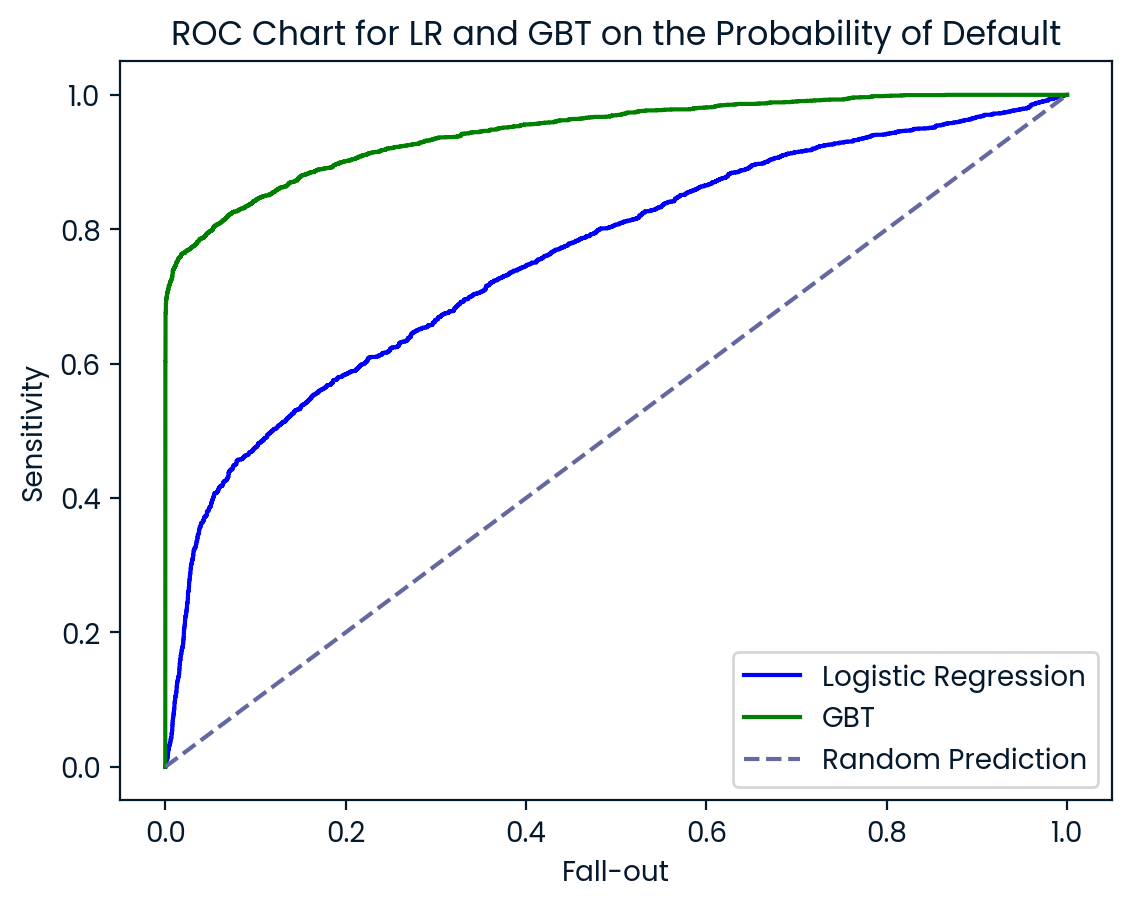

In [32]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, portfolio['lr_prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, portfolio['gbt_prob_default'])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

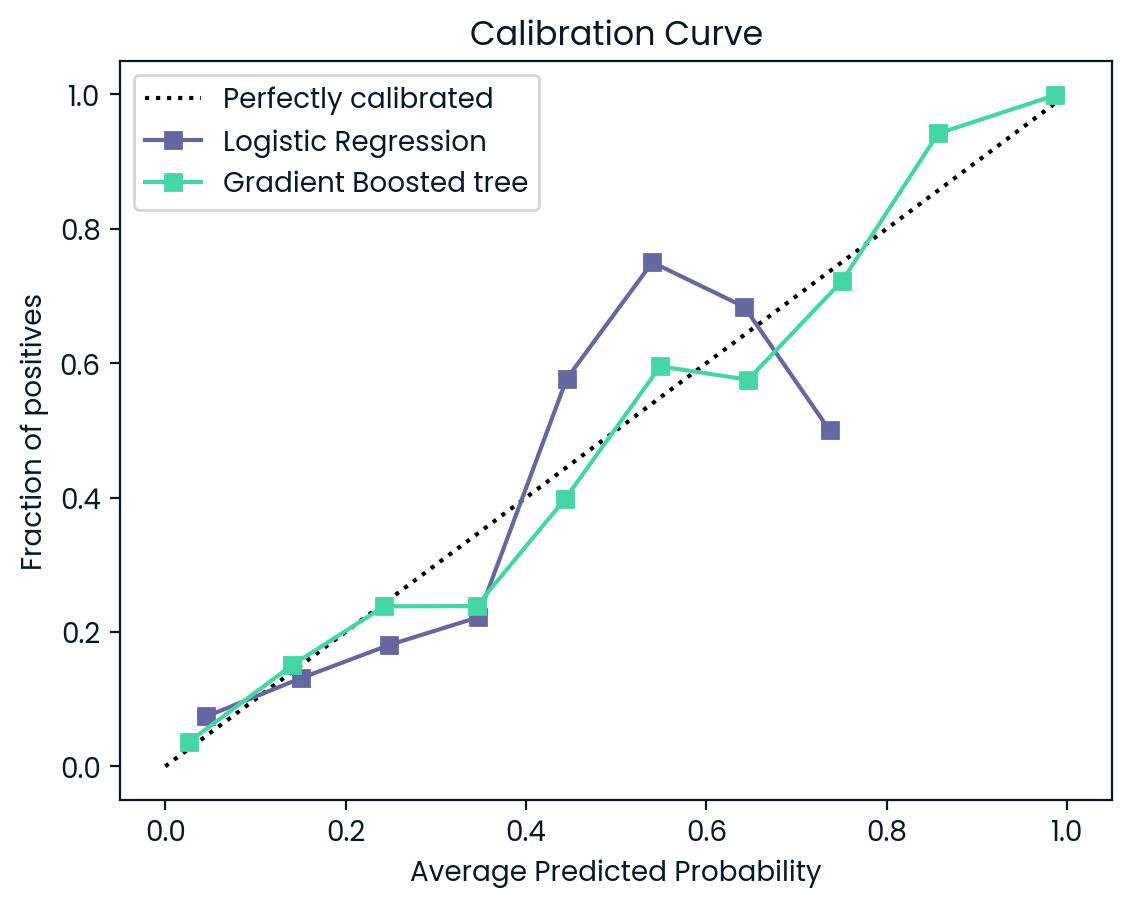

In [45]:
from sklearn.calibration import calibration_curve
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, portfolio['lr_prob_default'], n_bins = 10)
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, portfolio['gbt_prob_default'], n_bins = 10)

# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Notice that for the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes. We will be focusing on only the gbt model from now on.

### Acceptance Rate
Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept. 

With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?



       prob_default
count  11786.000000
mean       0.212839
std        0.344421
min        0.000002
25%        0.008941
50%        0.041768
75%        0.181321
max        1.000000


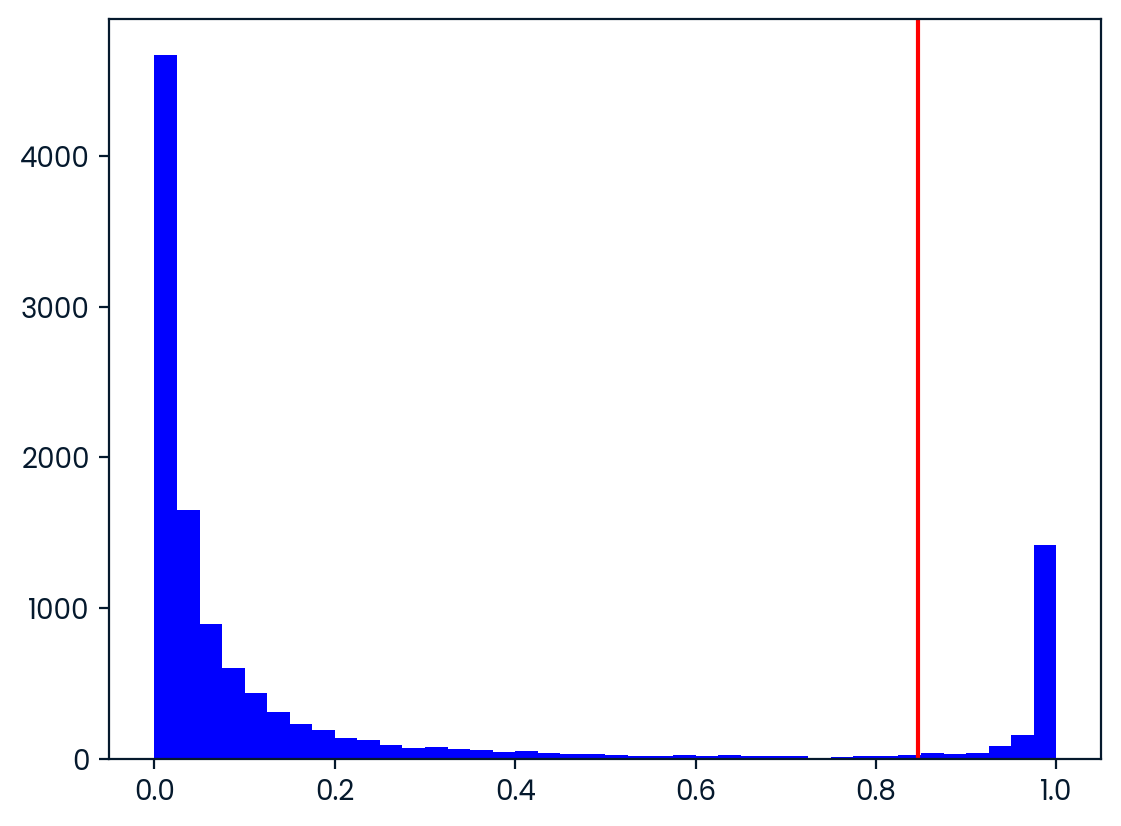

In [55]:
print(gbt_preds_df.describe())

# Plot the predicted probabilities of default
plt.hist(gbt_preds_df, color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold_85 = np.quantile(gbt_preds_df, 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold_85, color = 'red')
plt.show()

With acceptance rate in mind, you can now analyze the bad rate within the accepted loans. This way you will be able to see the percentage of defaults that have been accepted.

Think about the impact of the acceptance rate and bad rate. We set an acceptance rate to have fewer defaults in the portfolio because defaults are more costly. Will the bad rate be less than the percentage of defaults in the test data?

In [54]:
gbt_preds_df

,prob_default
0,0.069717
1,0.000514
2,0.001946
3,0.045644
4,0.432617
...,...
11781,0.041030
11782,0.998818
11783,0.981503
11784,0.002784


In [61]:
# Apply acceptance rate threshold
test_pred_df = pd.concat([gbt_preds_df.reset_index(drop=True), 
                          gbt_preds_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0).rename('pred_loan_status')], axis=1)
test_pred_df['true_loan_status'] = y_test.reset_index(drop=True)

# Print the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate, false negatives
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0    10018
1     1768
Name: pred_loan_status, dtype: int64
0.08285086843681373


In [63]:
test_pred_df['loan_amnt'] = X_test['loan_amnt'].reset_index(drop=True)

# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count   $11,786.00
mean     $9,524.92
std      $6,219.27
min        $500.00
25%      $5,000.00
50%      $8,000.00
75%     $12,000.00
max     $35,000.00
Name: loan_amnt, dtype: float64
pred_loan_status              0              1
true_loan_status                              
0                $87,514,939.92     $57,149.50
1                 $7,905,681.34 $16,782,904.24


With this, we can see that our bad rate of about 8% represents an estimated loan value of about 7.9 million dollars. This may seem like a lot at first, but compare it to the total value of non-default loans! With this, we are ready to start talking about our acceptance strategy going forward.

### Credit Strategy and minimum expected loss

In [64]:
test_pred_df

,prob_default,pred_loan_status,true_loan_status,loan_amnt
0,$0.07,0,0,9000
1,$0.00,0,0,11000
2,$0.00,0,0,3700
3,$0.05,0,0,10800
4,$0.43,0,0,7500
...,...,...,...,...
11781,$0.04,0,0,12000
11782,$1.00,1,1,8000
11783,$0.98,1,1,11900
11784,$0.00,0,0,10000


In [75]:
# analyse various acceptance rate
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Populate the arrays for the strategy table with a for loop
thresholds = []
bad_rates = []
num_accept = []
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    num_accept.append(len(test_pred_df['pred_loan_status']) - np.sum(test_pred_df['pred_loan_status']))
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accept),
                        columns = ['Acceptance Rate','Threshold','Bad Rate','Num Accepted Loans'])
strat_df['Avg Loan Amnt'] = np.mean(test_pred_df['loan_amnt'])
strat_df['Estimated Value'] = (strat_df['Num Accepted Loans']*(1-strat_df['Bad Rate'])*strat_df['Avg Loan Amnt']) - (strat_df['Num Accepted Loans']*strat_df['Bad Rate']*strat_df['Avg Loan Amnt'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  ...  Avg Loan Amnt  Estimated Value
0             $1.00      $1.00  ...      $9,524.92   $62,865,978.00
1             $0.95      $1.00  ...      $9,524.92   $68,359,950.28
2             $0.90      $0.99  ...      $9,524.92   $74,100,675.08
3             $0.85      $0.85  ...      $9,524.92   $79,580,798.13
4             $0.80      $0.31  ...      $9,524.92   $79,041,573.51
5             $0.75      $0.18  ...      $9,524.92   $75,737,379.71
6             $0.70      $0.12  ...      $9,524.92   $72,163,192.60
7             $0.65      $0.09  ...      $9,524.92   $67,990,650.19
8             $0.60      $0.07  ...      $9,524.92   $63,399,487.67
9             $0.55      $0.05  ...      $9,524.92   $58,798,266.83
10            $0.50      $0.04  ...      $9,524.92   $53,733,449.22
11            $0.45      $0.03  ...      $9,524.92   $48,728,676.68
12            $0.40      $0.03  ...      $9,524.92   $42,996,600.52
13            $0.35      $0.02  ...      $9,524.

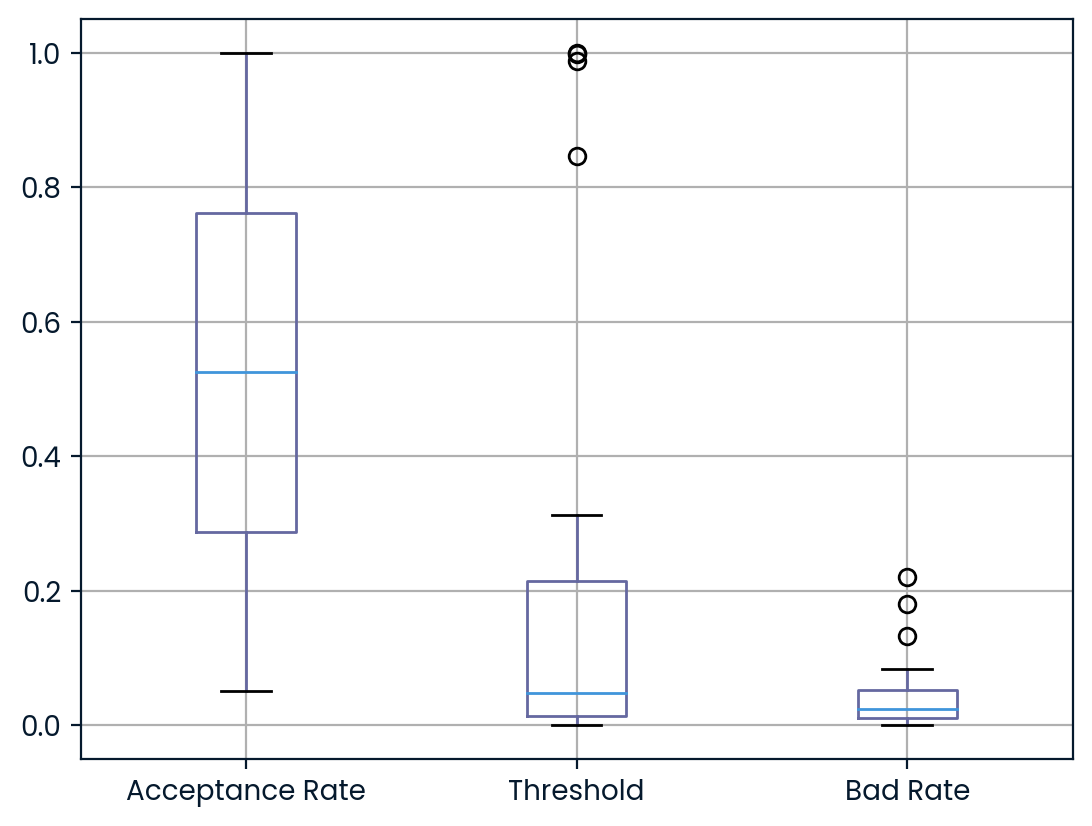

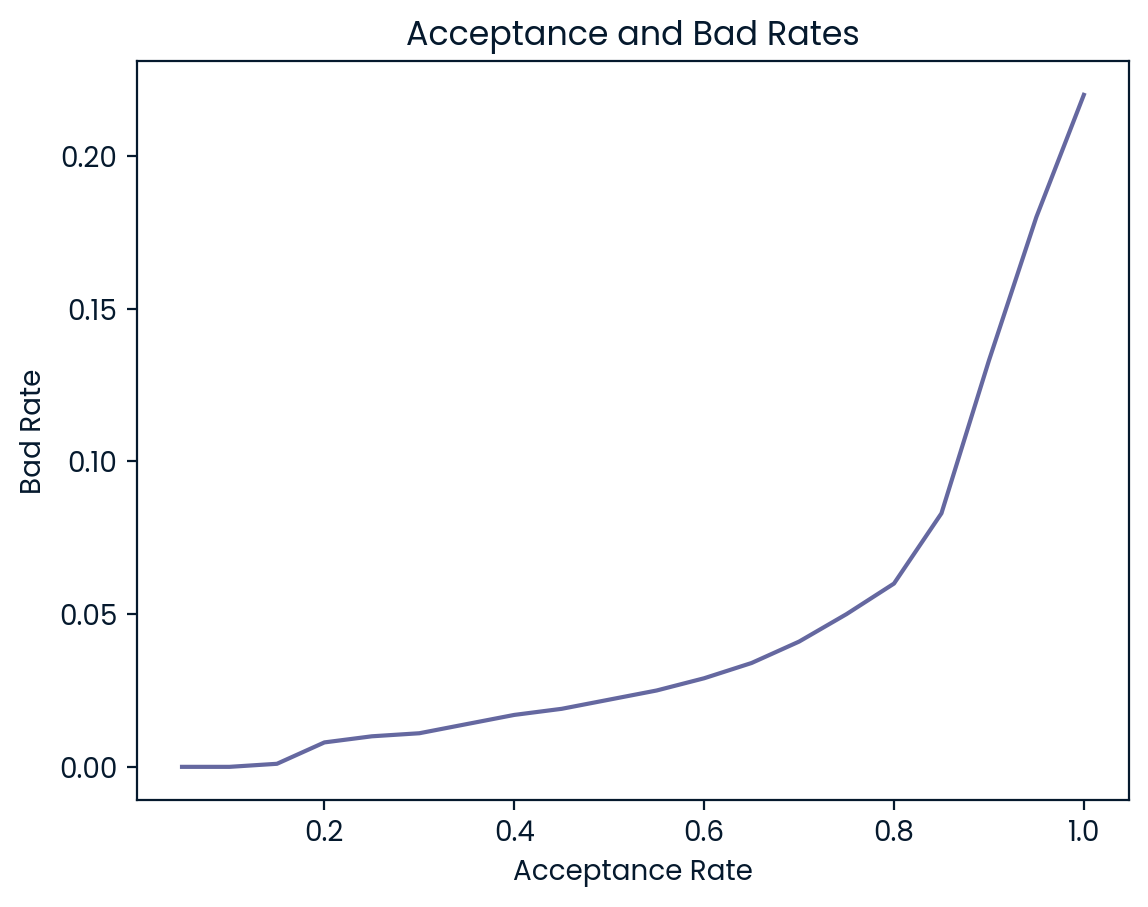

In [66]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.show()

The bad rates are very low up until the acceptance rate 0.6 where they suddenly increase. This suggests that many of the accepted defaults may have a prob_default value between 0.6 and 0.8.

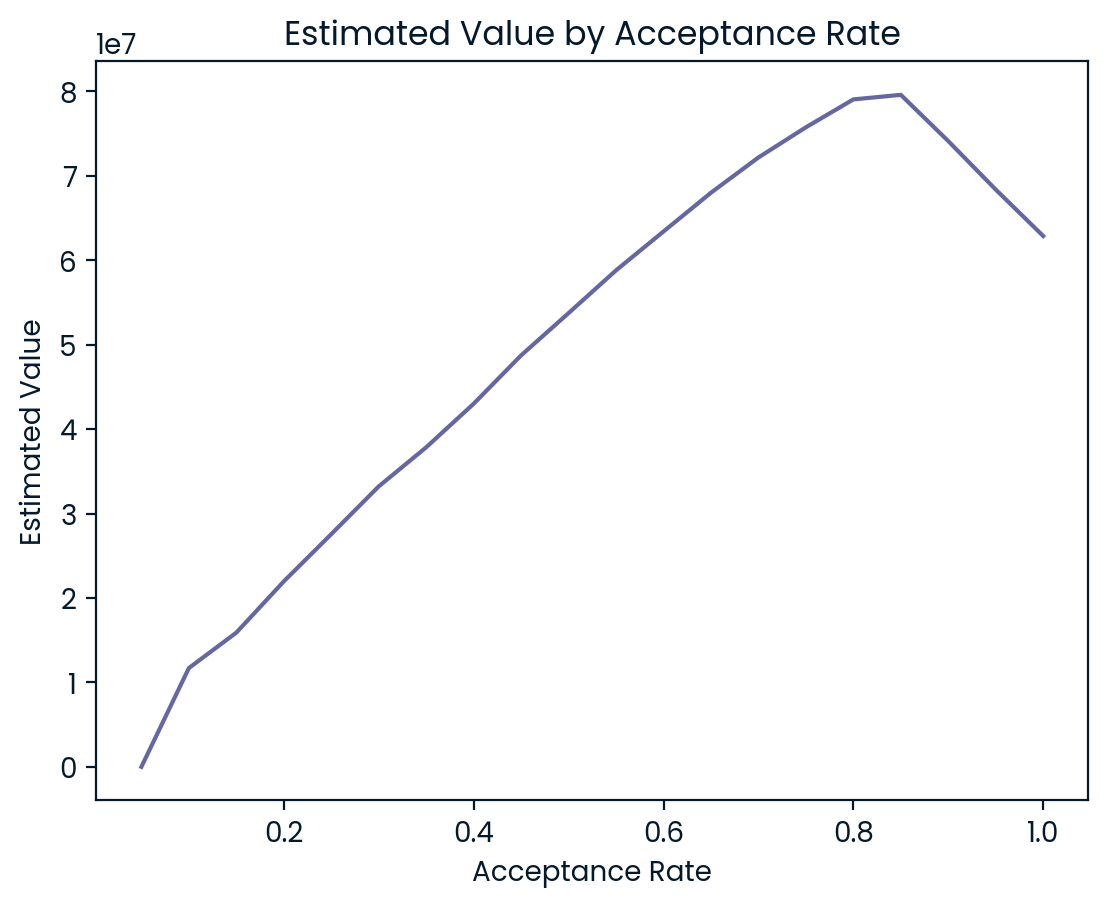

   Acceptance Rate  Threshold  ...  Avg Loan Amnt  Estimated Value
3            $0.85      $0.85  ...      $9,524.92   $79,580,798.13

[1 rows x 6 columns]


In [78]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.show()
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

In [80]:
# Print the first five rows of the data frame
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
#test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * 1.0 * test_pred_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   prob_default  pred_loan_status  true_loan_status  loan_amnt
0         $0.07                 1                 0       9000
1         $0.00                 1                 0      11000
2         $0.00                 1                 0       3700
3         $0.05                 1                 0      10800
4         $0.43                 1                 0       7500
Total expected loss:  $26,498,007.96
